In [1]:
import numpy as np

def compute_dissimilarity(dissimilarity_type, X, Y=None):
    if Y is None:
        Y = X

    M = X.shape[1]
    N = Y.shape[1]
    D = np.zeros((M, N))

    dissimilarity_type = dissimilarity_type.lower()

    if dissimilarity_type == 'euc':
        for i in range(M):
            for j in range(N):
                D[i, j] = np.linalg.norm(X[:, i] - Y[:, j])

    elif dissimilarity_type == 'euc2':
        for i in range(M):
            for j in range(N):
                D[i, j] = np.linalg.norm(X[:, i] - Y[:, j]) ** 2

    elif dissimilarity_type == 'l1':
        for i in range(M):
            for j in range(N):
                D[i, j] = np.linalg.norm(X[:, i] - Y[:, j], 1)

    elif dissimilarity_type == 'chi':
        for i in range(M):
            for j in range(N):
                D[i, j] = 0.5 * np.sum((X[:, i] - Y[:, j]) ** 2 / (X[:, i] + Y[:, j] + np.finfo(float).eps))

    elif dissimilarity_type == 'kl':
        for i in range(M):
            for j in range(N):
                D[i, j] = np.sum(Y[:, j] * np.log2((Y[:, j] + np.finfo(float).eps) / (X[:, i] + np.finfo(float).eps)))

    else:
        raise ValueError('Unknown dissimilarity type!')

    return D

In [2]:
import numpy as np

def compute_regularizer(D, q):
    Nr, Nc = D.shape
    _, idx = np.min(np.sum(D, axis=1)), np.argmin(np.sum(D, axis=1))
    
    rho_max = -np.inf
    idxC = np.setdiff1d(np.arange(Nr), idx)

    if q == 2:
        for i in range(Nr - 1):
            v = D[idxC[i], :] - D[idx, :]
            p = np.sqrt(Nr) * np.linalg.norm(v)**2 / (2 * np.sum(v))
            if p > rho_max:
                rho_max = p
    elif q == np.inf:
        for i in range(Nr - 1):
            v = D[idxC[i], :] - D[idx, :]
            p = np.linalg.norm(v, 1) / 2
            if p > rho_max:
                rho_max = p

    if Nr == Nc:
        rho_min = np.min(D + 1e10 * np.eye(Nr))
    else:
        rho_min = np.min(D)

    return rho_min, rho_max


In [3]:
import numpy as np

def error_coef(Z, C):
    err = np.sum(np.abs(Z - C)) / (Z.shape[0] * Z.shape[1])
    # err = np.max(np.abs(Z - C))  # 如果需要使用无穷范数来计算误差，可以将上面一行替换为这一行
    return err


In [4]:
import numpy as np

def find_representatives(C, ratio=0.1):
    N = C.shape[0]

    r = np.zeros(N)
    for i in range(N):
        r[i] = np.linalg.norm(C[i, :], np.inf)
    
    sInd = np.where(r >= ratio * np.linalg.norm(r, np.inf))[0]

    v = np.zeros(len(sInd))
    for i in range(len(sInd)):
        v[i] = np.linalg.norm(C[sInd[i], :], 2)

    pind = np.argsort(v)[::-1]  # Sort indices in descending order
    sInd = sInd[pind]

    return sInd


In [5]:
import numpy as np

def find_clustering(Z, sInd):
    N = Z.shape[1]
    membership = np.zeros(N, dtype=int)
    
    for i in range(N):
        t = np.argmax(Z[sInd, i])
        membership[i] = sInd[t]
    
    cluster_centers = np.unique(membership)
    clusters = np.zeros(N, dtype=int)

    for i, center in enumerate(cluster_centers):
        clusters[membership == center] = i + 1  # Assign cluster IDs starting from 1

    return clusters, cluster_centers


In [6]:
import numpy as np

def L2_Linf_shrink(y, t):
    x = np.copy(y)
    o = np.argsort(-np.abs(y))  # Sort indices by descending order of absolute values
    z = y[o]
    mz = np.abs(z)

    # Find cut-off index
    cs = np.cumsum(mz[:-1]) / np.arange(1, len(mz)) - t / np.arange(1, len(mz))
    d = cs > mz[1:]
    
    if np.sum(d) == 0:
        cut_index = len(y)
    else:
        cut_index = np.min(np.where(d == True)[0]) + 1  # Python indexing starts from 0

    # Shrink coordinates 1 to cut_index
    zbar = np.mean(mz[:cut_index])
    
    if cut_index < len(y):
        x[o[:cut_index]] = np.sign(z[:cut_index]) * np.maximum(zbar - t / cut_index, mz[cut_index])
    else:
        x[o[:cut_index]] = np.sign(z[:cut_index]) * np.maximum(zbar - t / cut_index, 0)

    return x


In [7]:
import numpy as np

def solver_BCLS_closedForm(U):
    m, N = U.shape
    V = np.sort(U, axis=0)[::-1]  # Sort U in descending order along each column
    active_set = np.arange(N)
    theta = np.zeros(N)
    i = 1
    
    while active_set.size > 0 and i <= m:
        idx = (V[i-1, active_set] - (np.sum(V[:i, active_set], axis=0) - 1) / i) <= 0
        theta[active_set[idx]] = (np.sum(V[:i-1, active_set[idx]], axis=0) - 1) / (i - 1)
        active_set = active_set[~idx]
        i += 1
    
    if active_set.size > 0:
        theta[active_set] = (np.sum(V[:m, active_set], axis=0) - 1) / m

    C = np.maximum(U - np.tile(theta, (m, 1)), 0)
    return C


In [8]:
import numpy as np

def shrink_L1Lp(C1, lambda_, p):
    if lambda_ is None or len(lambda_) == 0:
        return np.array([])

    D, N = C1.shape
    C2 = np.zeros_like(C1)

    if p == 1:
        C2 = np.maximum(np.abs(C1) - np.tile(lambda_, (N, 1)).T, 0) * np.sign(C1)
    
    elif p == 2:
        r = np.zeros(D)
        for j in range(D):
            r[j] = max(np.linalg.norm(C1[j, :]) - lambda_[j], 0)
        C2 = (r / (r + lambda_)).reshape(-1, 1) * C1
    
    elif p == np.inf:
        for j in range(D):
            C2[j, :] = L2_Linf_shrink(C1[j, :], lambda_[j])
    
    return C2


In [9]:
import numpy as np

def ds3solver_regularized(D, p=np.inf, options=None):
    if options is None:
        rho_min, rho_max = compute_regularizer(D, p)
        options = {
            'rho': 0.1 * rho_max,
            'mu': 1e-1,
            'maxIter': 3000,
            'errThr': 1e-7,
            'verbose': True
        }

    rho = options['rho']
    mu = options['mu']
    max_iter = options['maxIter']
    err_thr = options['errThr']
    verbose = options['verbose']
    CFD = np.ones(D.shape[0])
    ratio = 0.1

    # Initialization
    Nr, Nc = D.shape
    terminate = False
    k = 1
    _, idx = np.min(np.sum(D, axis=1)), np.argmin(np.sum(D, axis=1))
    C1 = np.zeros_like(D)
    C1[idx, :] = 1
    Lambda = np.zeros((Nr, Nc))

    # Running iterations
    while not terminate:
        Z = shrink_L1Lp(C1 - (Lambda + D) / mu, rho / mu * CFD, p)
        C2 = solver_BCLS_closedForm(Z + Lambda / mu)

        Lambda = Lambda + mu * (Z - C2)

        err1 = error_coef(Z, C2)
        err2 = error_coef(C1, C2)

        if k >= max_iter or (err1 <= err_thr and err2 <= err_thr):
            terminate = True
            if verbose:
                print('Terminating:')
                print(f'||Z-C||= {err1:.2e}, ||C1-C2||= {err2:.2e}, repNum = {len(find_representatives(C2))}, iteration = {k} \n')
        else:
            k += 1
            if verbose and k % 100 == 0:
                print(f'||Z-C||= {err1:.2e}, ||C1-C2||= {err2:.2e}, repNum = {len(find_representatives(C2))}, iteration = {k}')

        C1 = C2
    
    return C2



In [23]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results(Y, Z, sInd):
    # 绘制数据点和代表点
    plt.figure(figsize=(10, 8))
    plt.plot(Y[0, :], Y[1, :], 'o', linewidth=4, color='b', markersize=10, markerfacecolor='b', label='data points')
    plt.plot(Y[0, sInd], Y[1, sInd], '+', linewidth=6, color='r', markersize=16, label='representatives')
    plt.legend(fontsize=24, prop={'family': 'Times New Roman'})
    plt.gca().tick_params(labelsize=24)
    plt.show()

    # 绘制概率矩阵 Z 的热图
    plt.figure(figsize=(10, 8))
    plt.imshow(Z, aspect='auto', cmap='pink')
    h = plt.get_cmap('pink')
    plt.set_cmap(h.reversed())
    plt.colorbar()
    plt.gca().tick_params(labelsize=24)
    plt.show()

# 示例调用 plot_results 函数
# plot_results(Y, Z, sInd)


||Z-C||= 1.13e-02, ||C1-C2||= 7.39e-05, repNum = 105, iteration = 100
||Z-C||= 7.27e-03, ||C1-C2||= 5.99e-05, repNum = 105, iteration = 200
||Z-C||= 8.30e-04, ||C1-C2||= 2.24e-04, repNum = 12, iteration = 300
||Z-C||= 2.45e-04, ||C1-C2||= 3.04e-05, repNum = 5, iteration = 400
||Z-C||= 1.05e-04, ||C1-C2||= 1.11e-05, repNum = 4, iteration = 500
||Z-C||= 5.17e-05, ||C1-C2||= 9.83e-06, repNum = 3, iteration = 600
||Z-C||= 2.58e-05, ||C1-C2||= 3.07e-07, repNum = 3, iteration = 700
||Z-C||= 1.37e-05, ||C1-C2||= 1.50e-07, repNum = 3, iteration = 800
||Z-C||= 7.48e-06, ||C1-C2||= 7.64e-08, repNum = 3, iteration = 900
||Z-C||= 4.16e-06, ||C1-C2||= 4.04e-08, repNum = 3, iteration = 1000
||Z-C||= 2.36e-06, ||C1-C2||= 2.20e-08, repNum = 3, iteration = 1100
||Z-C||= 1.35e-06, ||C1-C2||= 1.22e-08, repNum = 3, iteration = 1200
||Z-C||= 7.74e-07, ||C1-C2||= 6.83e-09, repNum = 3, iteration = 1300
||Z-C||= 4.47e-07, ||C1-C2||= 3.86e-09, repNum = 3, iteration = 1400
||Z-C||= 2.60e-07, ||C1-C2||= 2.20e-09

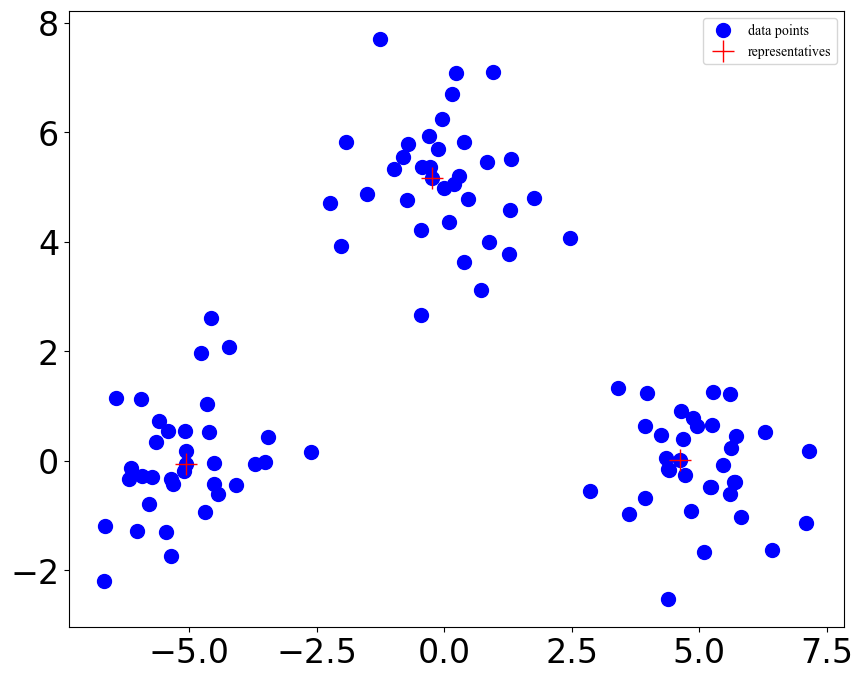

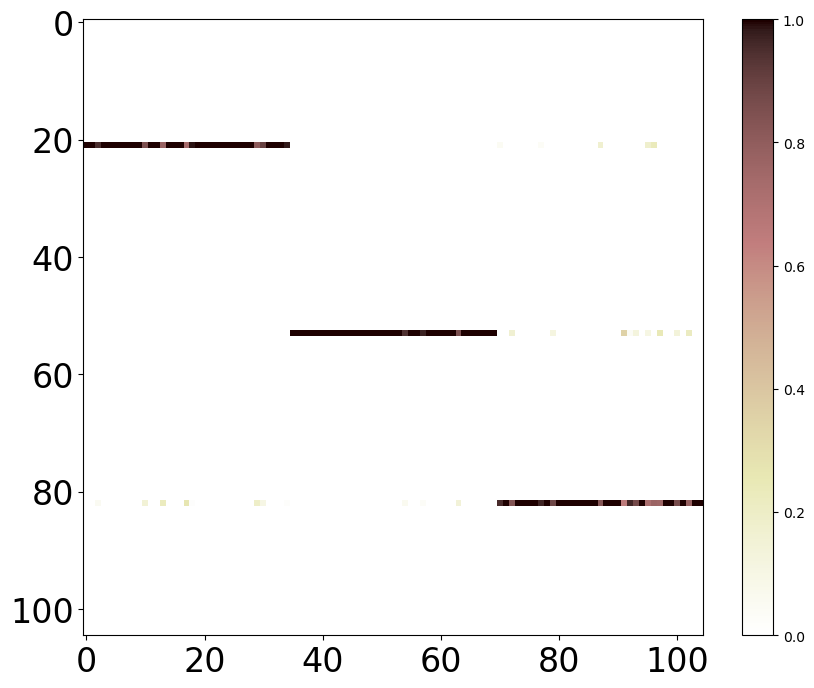

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# 设置随机数种子
np.random.seed(111)

# 参数设置
dissimilarityType = 'Euc'  # 成对不相似性的类型
# p = np.inf  # 用于DS3中L1/Lp优化的范数
p = 2
regularized = True  # True: 规范化版本, False: 约束版本
alpha = 0.3  # 正则化系数
verbose = True  # True/False: 显示/隐藏优化步骤

# 生成源集合和目标集合
Ng = 35  # 每个组中的点数
X = np.hstack([
    np.random.randn(2, Ng) + np.array([[-5], [0]]),
    np.random.randn(2, Ng) + np.array([[5], [0]]),
    np.random.randn(2, Ng) + np.array([[0], [5]])
])  # 源集合
Y = X  # 目标集合

# 计算D
D = compute_dissimilarity(dissimilarityType, X, Y)
D = D / np.max(D)

# 运行DS3
if regularized:
    rho_min, rho_max = compute_regularizer(D, p)
    options = {
        'verbose': verbose,
        'rho': alpha * rho_max,  # 正则化参数
        'mu': 1e-1,
        'maxIter': 3000,
        'errThr': 1e-7
    }
    Z = ds3solver_regularized(D, p, options)
else:
    print('woshishabi')

# 找到代表点和聚类
sInd = find_representatives(Z)
# clusters, clusterCenters = find_clustering(Z, sInd)
# 
# # 绘制结果
# def plot_results(Y, Z, sInd, clusterCenters):
#     plt.scatter(Y[0, :], Y[1, :], color='blue', marker='o', label='Data Points')
#     plt.scatter(Y[0, sInd], Y[1, sInd], color='red', marker='x', label='Representatives')
#     plt.title('DS3 Clustering Results')
#     plt.legend()
#     plt.show()

# 运行绘图函数
plot_results(Y, Z, sInd)


In [12]:
sInd

array([82, 21, 53], dtype=int64)